In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [24]:
import sys
sys.path.append('/Users/arthurbabey/Documents/master2/ML/road66/scripts')

from helpers import *

In [3]:
# Loaded a set of images
root_dir = "../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 20 # Only use 10 images for training

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


Image size = 400,400


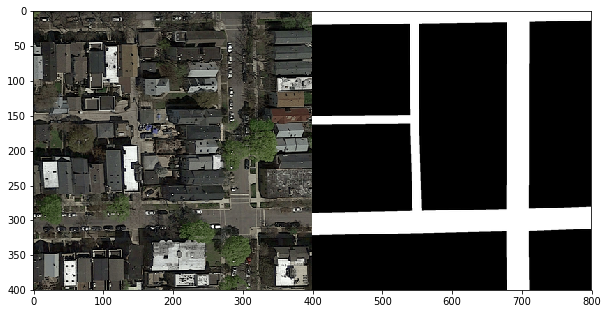

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[3], gt_imgs[3])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [29]:
# 
# Preparation training data
# 


# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Extract features
X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
print(X.shape)

# Features augmentation 
X = features_augmentation(X)

# Extract labels
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])


print('Computed ' + str(X.shape[1]) + ' features for ' + str(X.shape[0]) + ' patches')
print('Extracted ' + str(Y.shape[0]) + ' labels')

(12500, 6)
Computed 28 features for 12500 patches
Extracted 12500 labels


In [13]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [30]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 12500 features
Feature dimension = 28
Number of classes = 1
Class 0: 9763 samples
Class 1: 2737 samples


In [31]:
# 
# Run logistic regression 
# 
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [32]:
# 
# Preparation testing data
# 
root_testdir = "../Datasets/test_set_images"
test_names = os.listdir(root_testdir)

prefixes = ('.')
for dir_ in test_names[:]:
    if dir_.startswith(prefixes):
        test_names.remove(dir_)

# Get permutation to get test data in correct order
num_test = len(test_names)
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
p = np.argsort(order)

# Load data and reorder them
imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") for i in range(num_test)]
imgs_test = [imgs_test[i] for i in p]

# Crop images in patch and Linearize list of patches
img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(num_test)]
X_eval = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))]) 

# Extract, augment & standardize features
X_eval = np.asarray([ extract_features(X_eval[i]) for i in range(len(X_eval))])
X_eval = features_augmentation(X_eval)

print("Ready to predict!")

# 
# Prediction testing data
# 
Z_eval = logreg.predict(X_eval)
print("Prediction done!")


# 
# Save prediction
# 
create_submission(Z_eval, "submission_LogReg.csv")

submission_filename = 'dummy_submission.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    print image_filename
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

Ready to predict!
Prediction done!


In [26]:
def create_submission(y_pred, submission_filename, patch_size = 16, images_size = 608):
    n_patches = images_size // patch_size
    y_pred = np.reshape(y_pred, (-1, n_patches, n_patches))

    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(y_pred.shape[0]):
            img = y_pred[i]
            for j in range(img.shape[0]):
                for k in range(img.shape[1]):
                    name = '{:03d}_{}_{},{}'.format(i + 1, j * patch_size, k * patch_size, int(img[j,k]))
                    f.write(name + '\n')


In [28]:
from sklearn.preprocessing import PolynomialFeatures
def features_augmentation(X, polynomial_degree = 2):
    """
    Fit the dataset using a polynomial augmentation.
    By default the augmentation degree is 2.
    """
    polynomial = PolynomialFeatures(polynomial_degree, interaction_only=False, include_bias=True)
    return polynomial.fit_transform(X)

In [33]:
def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))
            
            
            

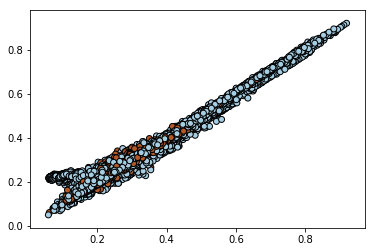

In [17]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [75]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [83]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.17732


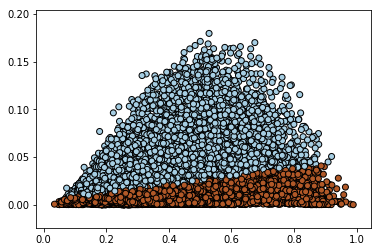

In [84]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

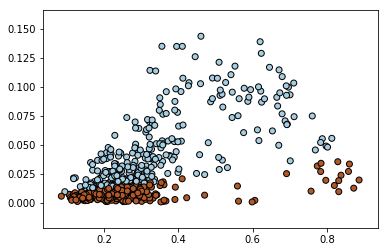

In [79]:
# Run prediction on the img_idx-th image
img_idx = 19

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

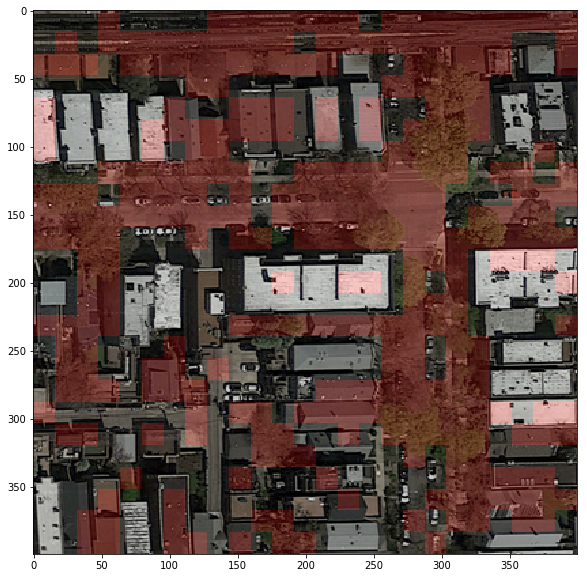

In [80]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)